In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error


In [24]:
# Loaing Data
def load_airline_data(filepath):
    """Load airline data with various fallback methods"""
    try:
        # Method 1: Standard load
        df = pd.read_csv(filepath)
        print("✓ Loaded successfully with standard method")
        return df
    except:
        pass

    try:
        # Method 2: Skip bad lines
        df = pd.read_csv(filepath, on_bad_lines='skip')
        print("Loaded with some lines skipped")
        return df
    except:
        pass

    try:
        # Method 3: Use different engine
        df = pd.read_csv(filepath, engine='python')
        print("Loaded with Python engine")
        return df
    except Exception as e:
        print(f"All methods failed: {e}")
        return None

def load_temperature_data(filepath):
    """Load temperature data with error handling"""
    try:
        df = pd.read_csv(filepath)
        df.columns = ['date', 'temp'] # Rename for simplicity
        df['date'] = pd.to_datetime(df['date'])
        df['temp'] = pd.to_numeric(df['temp'], errors='coerce')  # CRITICAL: Convert to float
        df = df.dropna()
        df = df.set_index('date')

        print("Loaded successfully")
        return df
    except:
        try:
            df = pd.read_csv(filepath, on_bad_lines='skip')
            df.columns = ['date', 'temp']
            df['date'] = pd.to_datetime(df['date'])
            df['temp'] = pd.to_numeric(df['temp'], errors='coerce')  # CRITICAL: Convert to float
            df = df.dropna()
            df = df.set_index('date')
            print("Loaded with some lines skipped")
            return df
        except Exception as e:
            print(f"Failed to load: {e}")
            return None

# Load the data
print("Loading Airline Data...")
airline = load_airline_data('/content/airline-passengers.csv')

print("\nLoading Temperature Data...")
temps = load_temperature_data('/content/daily-minimum-temperatures-in-me.csv')

# Inspect data
if airline is not None:
    print("\nAirline Data Info:")
    print(airline.head())
    print(f"Shape: {airline.shape}")
    print(f"Columns: {airline.columns.tolist()}")

if temps is not None:
    print("\nTemperature Data Info:")
    print(temps.head())
    print(f"Shape: {temps.shape}")
    print(f"Columns: {temps.columns.tolist()}")

Loading Airline Data...
✓ Loaded successfully with standard method

Loading Temperature Data...
Loaded with some lines skipped

Airline Data Info:
     month  total_passengers
0  1949-01               112
1  1949-02               118
2  1949-03               132
3  1949-04               129
4  1949-05               121
Shape: (144, 2)
Columns: ['month', 'total_passengers']

Temperature Data Info:
            temp
date            
1981-01-01  20.7
1981-01-02  17.9
1981-01-03  18.8
1981-01-04  14.6
1981-01-05  15.8
Shape: (3647, 1)
Columns: ['temp']


In [25]:
def naive_forecast(train_series, horizon):
    """
    Naive forecast: last value repeated h times

    Args:
        train_series: pandas Series with training data
        horizon: int, number of periods to forecast

    Returns:
        numpy array of forecasts
    """
    last_value = train_series.iloc[-1]
    return np.full(horizon, last_value)


# Test
test_forecast = naive_forecast(airline['total_passengers'], 6)
print(f"Naive forecast (6 months): {test_forecast}")

Naive forecast (6 months): [432 432 432 432 432 432]


In [3]:
def seasonal_naive_forecast(train_series, horizon, season_length):
    """
    Seasonal naive: repeat values from the same season last year

    Args:
        train_series: pandas Series with training data
        horizon: int, number of periods to forecast
        season_length: int, seasonal period (12 for monthly, 365 for daily)

    Returns:
        numpy array of forecasts
    """
    forecasts = []
    train_values = train_series.values
    n = len(train_values)

    for h in range(horizon):
        # Get value from same position in previous season
        seasonal_lag = n - season_length + (h % season_length)

        # Handle edge case where we don't have enough history
        if seasonal_lag < 0:
            seasonal_lag = n - 1  # Fall back to last value

        forecasts.append(train_values[seasonal_lag])

    return np.array(forecasts)


# Test
test_snaive = seasonal_naive_forecast(airline['total_passengers'], 12, 12)
print(f"Seasonal naive forecast (12 months): {test_snaive}")

Seasonal naive forecast (12 months): [417 391 419 461 472 535 622 606 508 461 390 432]


In [4]:
def calculate_all_metrics(actual, forecast, train_series, season_length=1):
    """
    Calculate MAE, RMSE, sMAPE, and MASE
    """
    actual = np.array(actual)
    forecast = np.array(forecast)

    # MAE
    mae = mean_absolute_error(actual, forecast)

    # RMSE
    rmse = np.sqrt(mean_squared_error(actual, forecast))

    # sMAPE (symmetric MAPE)
    smape = np.mean(2.0 * np.abs(forecast - actual) / (np.abs(actual) + np.abs(forecast))) * 100

    # MASE (Mean Absolute Scaled Error)
    # Scale by naive forecast error on training data
    train_values = train_series.values
    if season_length == 1:
        # Non-seasonal: one-step naive errors
        naive_errors = np.abs(np.diff(train_values))
    else:
        # Seasonal naive errors
        naive_errors = np.abs(train_values[season_length:] - train_values[:-season_length])

    scale = np.mean(naive_errors)
    mase = mae / scale if scale > 0 else np.nan

    return {
        'MAE': mae,
        'RMSE': rmse,
        'sMAPE': smape,
        'MASE': mase
    }

In [5]:
def rolling_origin_forecast(data_series, forecast_func, horizons,
                           n_origins=10, season_length=None):
    """
    Perform expanding-window backtesting

    Args:
        data_series: pandas Series with full dataset
        forecast_func: function that takes (train, horizon, *args)
        horizons: list of forecast horizons to test
        n_origins: number of different origin points
        season_length: seasonal period (for seasonal_naive)

    Returns:
        Dictionary with results for each horizon
    """
    max_horizon = max(horizons)
    total_length = len(data_series)

    test_reserve = max_horizon * n_origins
    min_train_size = total_length - test_reserve

    if season_length:
        min_train_size = max(min_train_size, season_length * 2)

    results = {h: {'forecasts': [], 'actuals': [], 'origins': []} for h in horizons}

    for i in range(n_origins):
        train_end_idx = min_train_size + (i * max_horizon)

        if train_end_idx + max_horizon > total_length:
            break

        train = data_series.iloc[:train_end_idx]

        for h in horizons:
            if train_end_idx + h > total_length:
                continue

            # Generate forecast
            if season_length:
                forecast = forecast_func(train, h, season_length)
            else:
                forecast = forecast_func(train, h)

            # Get actual values
            actual = data_series.iloc[train_end_idx:train_end_idx + h].values

            results[h]['forecasts'].append(forecast)
            results[h]['actuals'].append(actual)
            results[h]['origins'].append(train_end_idx)

    return results

In [20]:
# AIRLINE PASSENGERS ANALYSIS
print("AIRLINE PASSENGERS - NAIVE FORECASTING")

horizons_airline = [1, 6, 12]
season_length_airline = 12

# Naive Model
naive_airline_results = rolling_origin_forecast(
    airline['total_passengers'],
    naive_forecast,
    horizons_airline,
    n_origins=10,
    season_length=None
)

# Seasonal-Naive Model
snaive_airline_results = rolling_origin_forecast(
    airline['total_passengers'],
    seasonal_naive_forecast,
    horizons_airline,
    n_origins=10,
    season_length=season_length_airline
)

# Calculate metrics
airline_results_table = []

for h in horizons_airline:
    # Naive
    all_forecasts_naive = np.concatenate(naive_airline_results[h]['forecasts'])
    all_actuals_naive = np.concatenate(naive_airline_results[h]['actuals'])

    # Use first 80% of data as "train" for MASE calculation
    train_for_mase = airline['total_passengers'].iloc[:int(len(airline)*0.8)]

    metrics_naive = calculate_all_metrics(
        all_actuals_naive,
        all_forecasts_naive,
        train_for_mase,
        season_length=1
    )

    airline_results_table.append({
        'Dataset': 'Airline',
        'Model': 'Naive',
        'Horizon': h,
        **metrics_naive
    })

    # Seasonal-Naive
    all_forecasts_snaive = np.concatenate(snaive_airline_results[h]['forecasts'])
    all_actuals_snaive = np.concatenate(snaive_airline_results[h]['actuals'])

    metrics_snaive = calculate_all_metrics(
        all_actuals_snaive,
        all_forecasts_snaive,
        train_for_mase,
        season_length=season_length_airline
    )

    airline_results_table.append({
        'Dataset': 'Airline',
        'Model': 'Seasonal-Naive',
        'Horizon': h,
        **metrics_snaive
    })

# Display results
airline_df = pd.DataFrame(airline_results_table)
print("\nAirline Passengers Results:")
print(airline_df.to_string(index=False))

AIRLINE PASSENGERS - NAIVE FORECASTING

Airline Passengers Results:
Dataset          Model  Horizon       MAE      RMSE     sMAPE     MASE
Airline          Naive        1  8.200000 10.188229  3.024006 0.389338
Airline Seasonal-Naive        1 30.200000 32.723081 12.853681 1.026601
Airline          Naive        6 36.366667 48.248316 12.905536 1.726697
Airline Seasonal-Naive        6 32.300000 36.362985 12.478779 1.097987
Airline          Naive       12 52.425000 72.408160 17.418935 2.489150
Airline Seasonal-Naive       12 33.933333 37.799030 12.341450 1.153509


In [22]:
# TEMPERATURE ANALYSIS
print("DAILY MINIMUM TEMPERATURES - NAIVE FORECASTING")

horizons_temps = [1, 7, 14]
season_length_temps = 365

temp_col = 'temp'

# Double-check data type before analysis
print(f"Temperature data type: {temps[temp_col].dtype}")

# Naive Model
naive_temps_results = rolling_origin_forecast(
    temps[temp_col],
    naive_forecast,
    horizons_temps,
    n_origins=10,
    season_length=None
)

# Seasonal-Naive Model
snaive_temps_results = rolling_origin_forecast(
    temps[temp_col],
    seasonal_naive_forecast,
    horizons_temps,
    n_origins=10,
    season_length=season_length_temps
)

# Calculate metrics
temps_results_table = []
train_for_mase = temps[temp_col].iloc[:int(len(temps)*0.8)]

for h in horizons_temps:
    # Naive
    all_forecasts_naive = np.concatenate(naive_temps_results[h]['forecasts'])
    all_actuals_naive = np.concatenate(naive_temps_results[h]['actuals'])

    # Ensuring arrays are numeric
    all_forecasts_naive = all_forecasts_naive.astype(float)
    all_actuals_naive = all_actuals_naive.astype(float)

    metrics_naive = calculate_all_metrics(
        all_actuals_naive,
        all_forecasts_naive,
        train_for_mase,
        season_length=1
    )

    temps_results_table.append({
        'Dataset': 'Temperature',
        'Model': 'Naive',
        'Horizon': h,
        **metrics_naive
    })

    # Seasonal-Naive
    all_forecasts_snaive = np.concatenate(snaive_temps_results[h]['forecasts'])
    all_actuals_snaive = np.concatenate(snaive_temps_results[h]['actuals'])

    # Ensuring arrays are numeric
    all_forecasts_snaive = all_forecasts_snaive.astype(float)
    all_actuals_snaive = all_actuals_snaive.astype(float)

    metrics_snaive = calculate_all_metrics(
        all_actuals_snaive,
        all_forecasts_snaive,
        train_for_mase,
        season_length=season_length_temps
    )

    temps_results_table.append({
        'Dataset': 'Temperature',
        'Model': 'Seasonal-Naive',
        'Horizon': h,
        **metrics_snaive
    })

temps_df = pd.DataFrame(temps_results_table)
print("\nDaily Temperature Results:")
print(temps_df.round(2).to_string(index=False))

DAILY MINIMUM TEMPERATURES - NAIVE FORECASTING
Temperature data type: float64

Daily Temperature Results:
    Dataset          Model  Horizon  MAE  RMSE  sMAPE  MASE
Temperature          Naive        1 3.26  3.64  33.78  1.50
Temperature Seasonal-Naive        1 3.52  4.38  32.55  1.12
Temperature          Naive        7 3.06  3.92  33.83  1.40
Temperature Seasonal-Naive        7 3.09  4.00  28.46  0.98
Temperature          Naive       14 3.05  3.86  34.20  1.40
Temperature Seasonal-Naive       14 2.92  3.71  28.02  0.93


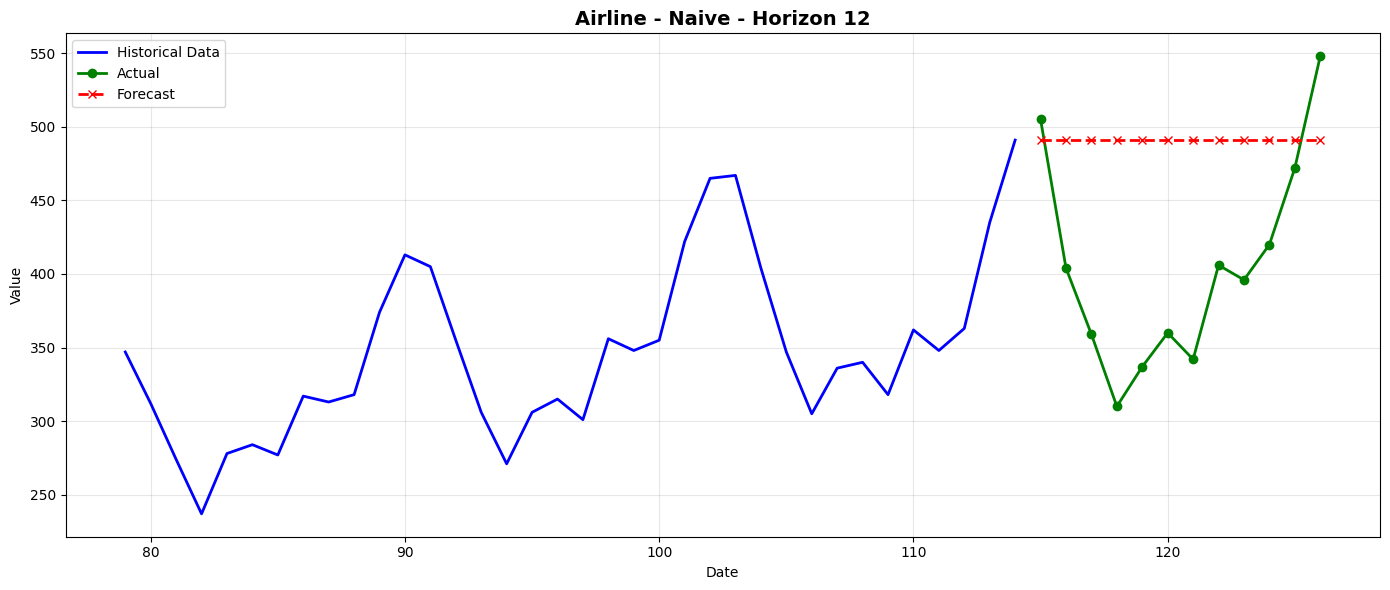

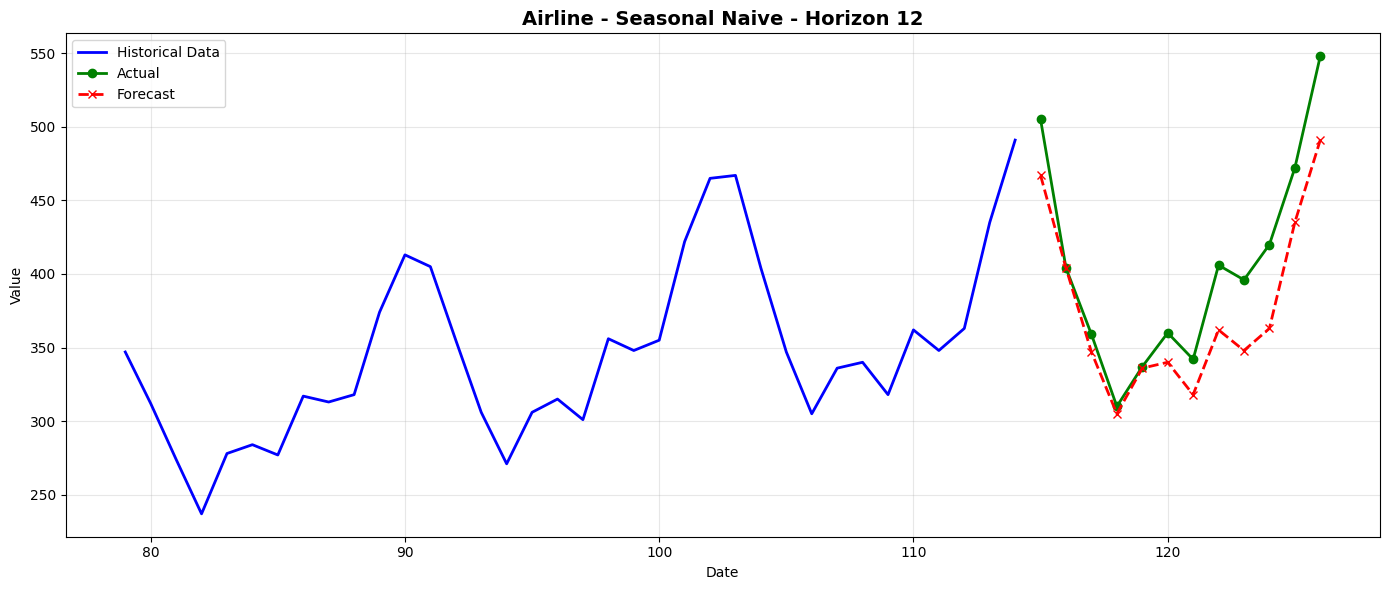

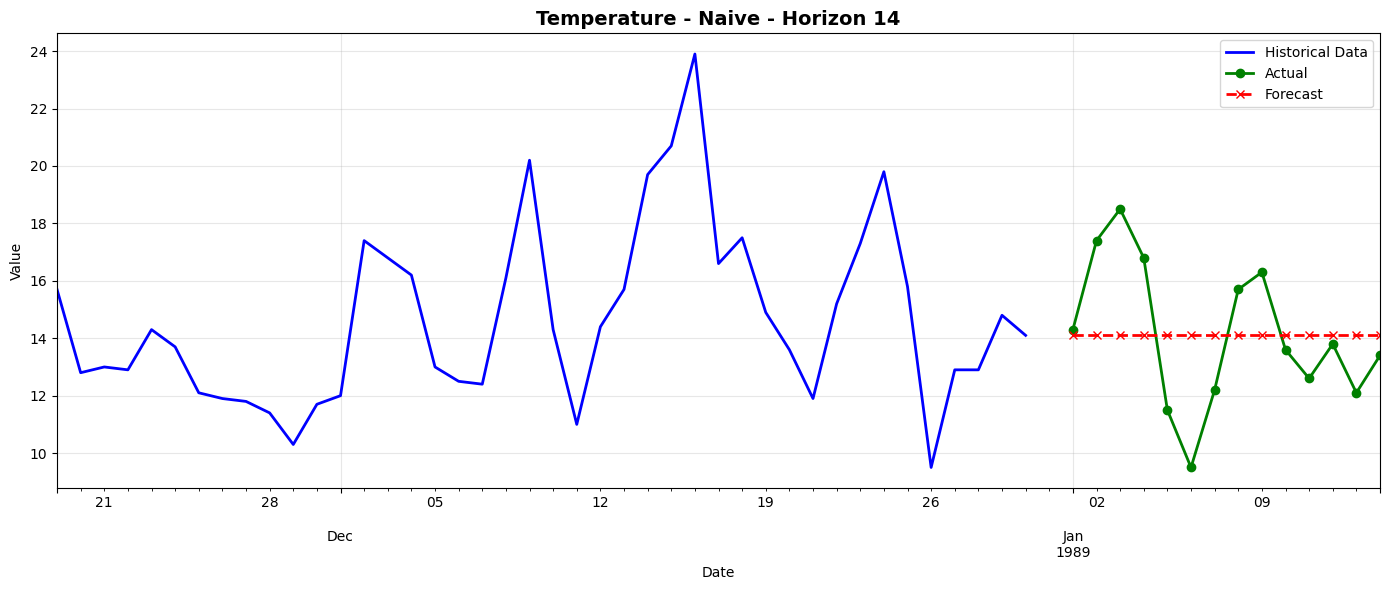

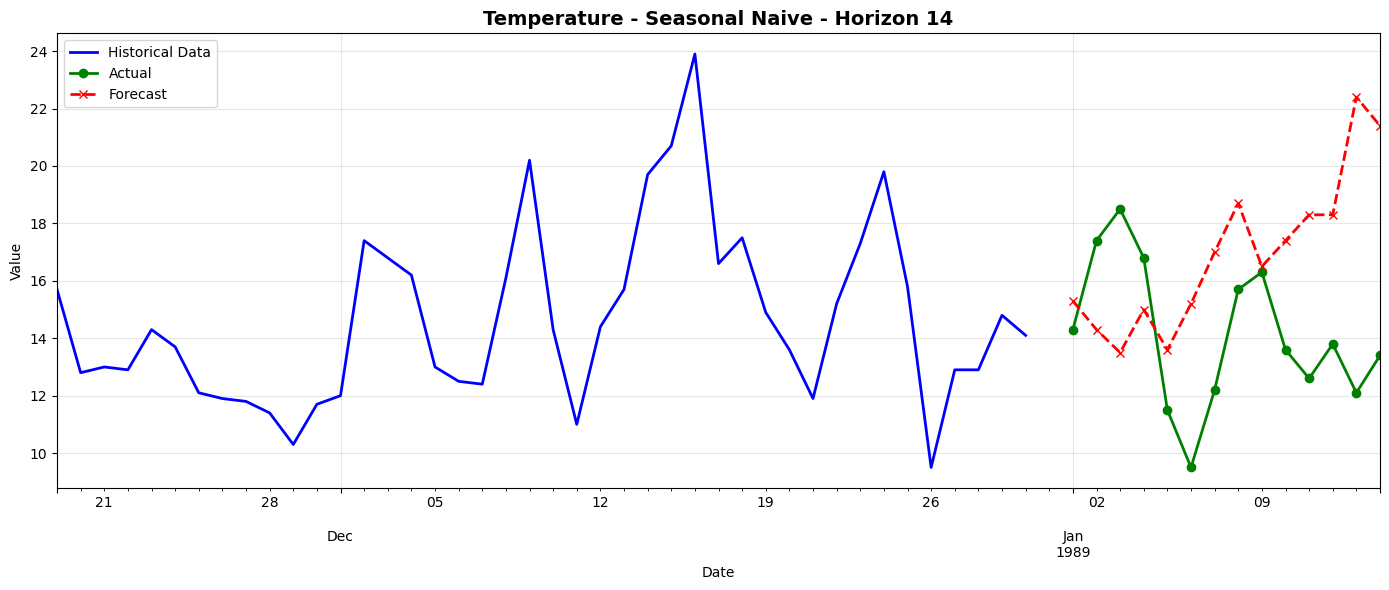

In [17]:
def plot_last_year_forecast(data_series, model_name, horizon, season_length=None):
    """
    Plot last year of data with forecast overlay
    """
    # Use last 20% as test, rest as train
    split_point = int(len(data_series) * 0.8)
    train = data_series.iloc[:split_point]
    test = data_series.iloc[split_point:split_point + horizon]

    # Generate forecast
    if season_length:
        forecast = seasonal_naive_forecast(train, horizon, season_length)
    else:
        forecast = naive_forecast(train, horizon)

    # Plot
    plt.figure(figsize=(14, 6))

    # Last portion of training data
    lookback = min(len(train), horizon * 3)
    train.iloc[-lookback:].plot(label='Historical Data', color='blue', linewidth=2)

    # Actual test data
    test.plot(label='Actual', color='green', linewidth=2, marker='o')

    # Forecast
    forecast_series = pd.Series(forecast, index=test.index[:len(forecast)])
    forecast_series.plot(label='Forecast', color='red', linewidth=2,
                        linestyle='--', marker='x')

    plt.title(f'{model_name} - Horizon {horizon}', fontsize=14, fontweight='bold')
    plt.xlabel('Date')
    plt.ylabel('Value')
    plt.legend(loc='best')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()


# Create visualizations for airline data
plot_last_year_forecast(airline['total_passengers'], 'Airline - Naive', 12, None)
plot_last_year_forecast(airline['total_passengers'], 'Airline - Seasonal Naive', 12, 12)

# Create visualizations for temperature data
plot_last_year_forecast(temps['temp'], 'Temperature - Naive', 14, None)
plot_last_year_forecast(temps['temp'], 'Temperature - Seasonal Naive', 14, 365)

In [23]:
# Combine both datasets into one table
all_results = pd.concat([airline_df, temps_df], ignore_index=True)

# Format for presentation
all_results_formatted = all_results.round(2)
print(all_results_formatted.to_string(index=False))

# Save to CSV
all_results_formatted.to_csv('naive_models_results.csv', index=False)
print("\nResults saved to 'naive_models_results.csv'")

    Dataset          Model  Horizon   MAE  RMSE  sMAPE  MASE
    Airline          Naive        1  8.20 10.19   3.02  0.39
    Airline Seasonal-Naive        1 30.20 32.72  12.85  1.03
    Airline          Naive        6 36.37 48.25  12.91  1.73
    Airline Seasonal-Naive        6 32.30 36.36  12.48  1.10
    Airline          Naive       12 52.42 72.41  17.42  2.49
    Airline Seasonal-Naive       12 33.93 37.80  12.34  1.15
Temperature          Naive        1  3.26  3.64  33.78  1.50
Temperature Seasonal-Naive        1  3.52  4.38  32.55  1.12
Temperature          Naive        7  3.06  3.92  33.83  1.40
Temperature Seasonal-Naive        7  3.09  4.00  28.46  0.98
Temperature          Naive       14  3.05  3.86  34.20  1.40
Temperature Seasonal-Naive       14  2.92  3.71  28.02  0.93

Results saved to 'naive_models_results.csv'
